# City of Ottawa bicycle count data analysis

This notebook loads the bicycle count data, does some minimal cleaning, and produces a few figures.

The data was downloaded from the [City of Ottawa open data portal](https://open.ottawa.ca/datasets/bicycle-trip-counters).

In [2]:
# load packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [5]:
# load the excel file using pandas
# requires the package openpyxl
xls = pd.ExcelFile('data/bike_counter.xlsx')

The Excel file the city provides has a different sheet for each year of data collection. We can load the entire file and then loop through each of the sheets.

In [6]:
# the date and header format for 2010-2012 is different, will require extra parsing
# 2013 has a note at the bottom which breaks the parsing
# for now, stick to year >= 2014
years = np.arange(2014, 2021, 1)
dataframes = []
for year in years:
    dataframes.append(pd.read_excel(xls, str(year), header = 0))

In [7]:
# smoosh all the years together into one big table
count_data = pd.concat(dataframes)

In [8]:
# take a look at the column names (these are mostly locations)
count_data.columns

Index(['Date', '1^ALEX', '2^ORPY', '3^COBY', '4^CRTZ', '5^LMET', '6^LLYN',
       '8^SOMO', '9 OYNG 1', '10^OGLD', '11 OBVW', 'Portage Bridge',
       '12a^ADAWE', '12b^ADAWE', 'Unnamed: 10', 'Note:',
       '1. ALEX: internal Battery failed in August 2019.'],
      dtype='object')

In [9]:
# the date format varies somewhat, so convert them to pandas datetime for consistency
count_data['date_dt'] = pd.to_datetime(count_data['Date'])

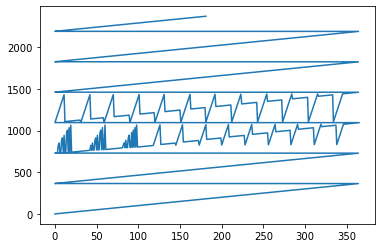

In [10]:
# some of the dates aren't in order...
plt.plot(np.argsort(count_data['date_dt']))

In [11]:
# sort the table so that all the dates are in sequential order (helps with plotting)
count_data = count_data.sort_values(by = 'date_dt')

Text(0, 0.5, 'Count')

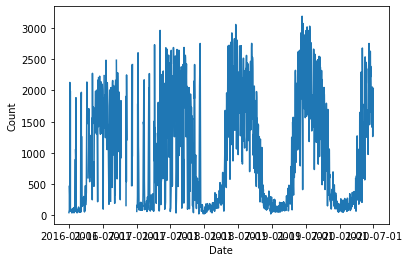

In [12]:
# plot one location to get a feel for the data
fig, ax = plt.subplots()

ax.plot(count_data['date_dt'], count_data['12a^ADAWE'])

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel("Date")
ax.set_ylabel("Count")

In [13]:
# drop columns created from text notes
count_data = count_data.drop(columns=['Unnamed: 10', 'Note:', '1. ALEX: internal Battery failed in August 2019.'])

In [14]:
# check out what's left after dropping unused columns
count_data.columns

Index(['Date', '1^ALEX', '2^ORPY', '3^COBY', '4^CRTZ', '5^LMET', '6^LLYN',
       '8^SOMO', '9 OYNG 1', '10^OGLD', '11 OBVW', 'Portage Bridge',
       '12a^ADAWE', '12b^ADAWE', 'date_dt'],
      dtype='object')

In [15]:
# reshape data to long format for faceting
count_data = pd.melt(count_data, id_vars = ['Date', 'date_dt'])

In [16]:
# get month-day for overlaying plots
# use dt.strftime('%b-%d' for months in abbreviated words)
count_data['month_day'] = count_data['date_dt'].dt.strftime('%m-%d')

In [17]:
# rename variable and value columns resulting from melt
count_data = count_data.rename(columns={"variable": "location", "value": "count"})

In [18]:
# convert counts to numbers, make dashes into NaN
count_data['count'] = pd.to_numeric(count_data['count'], errors = 'coerce')

In [19]:
# make year and month columns
count_data['year'] = count_data['date_dt'].dt.year
count_data['month'] = count_data['date_dt'].dt.month

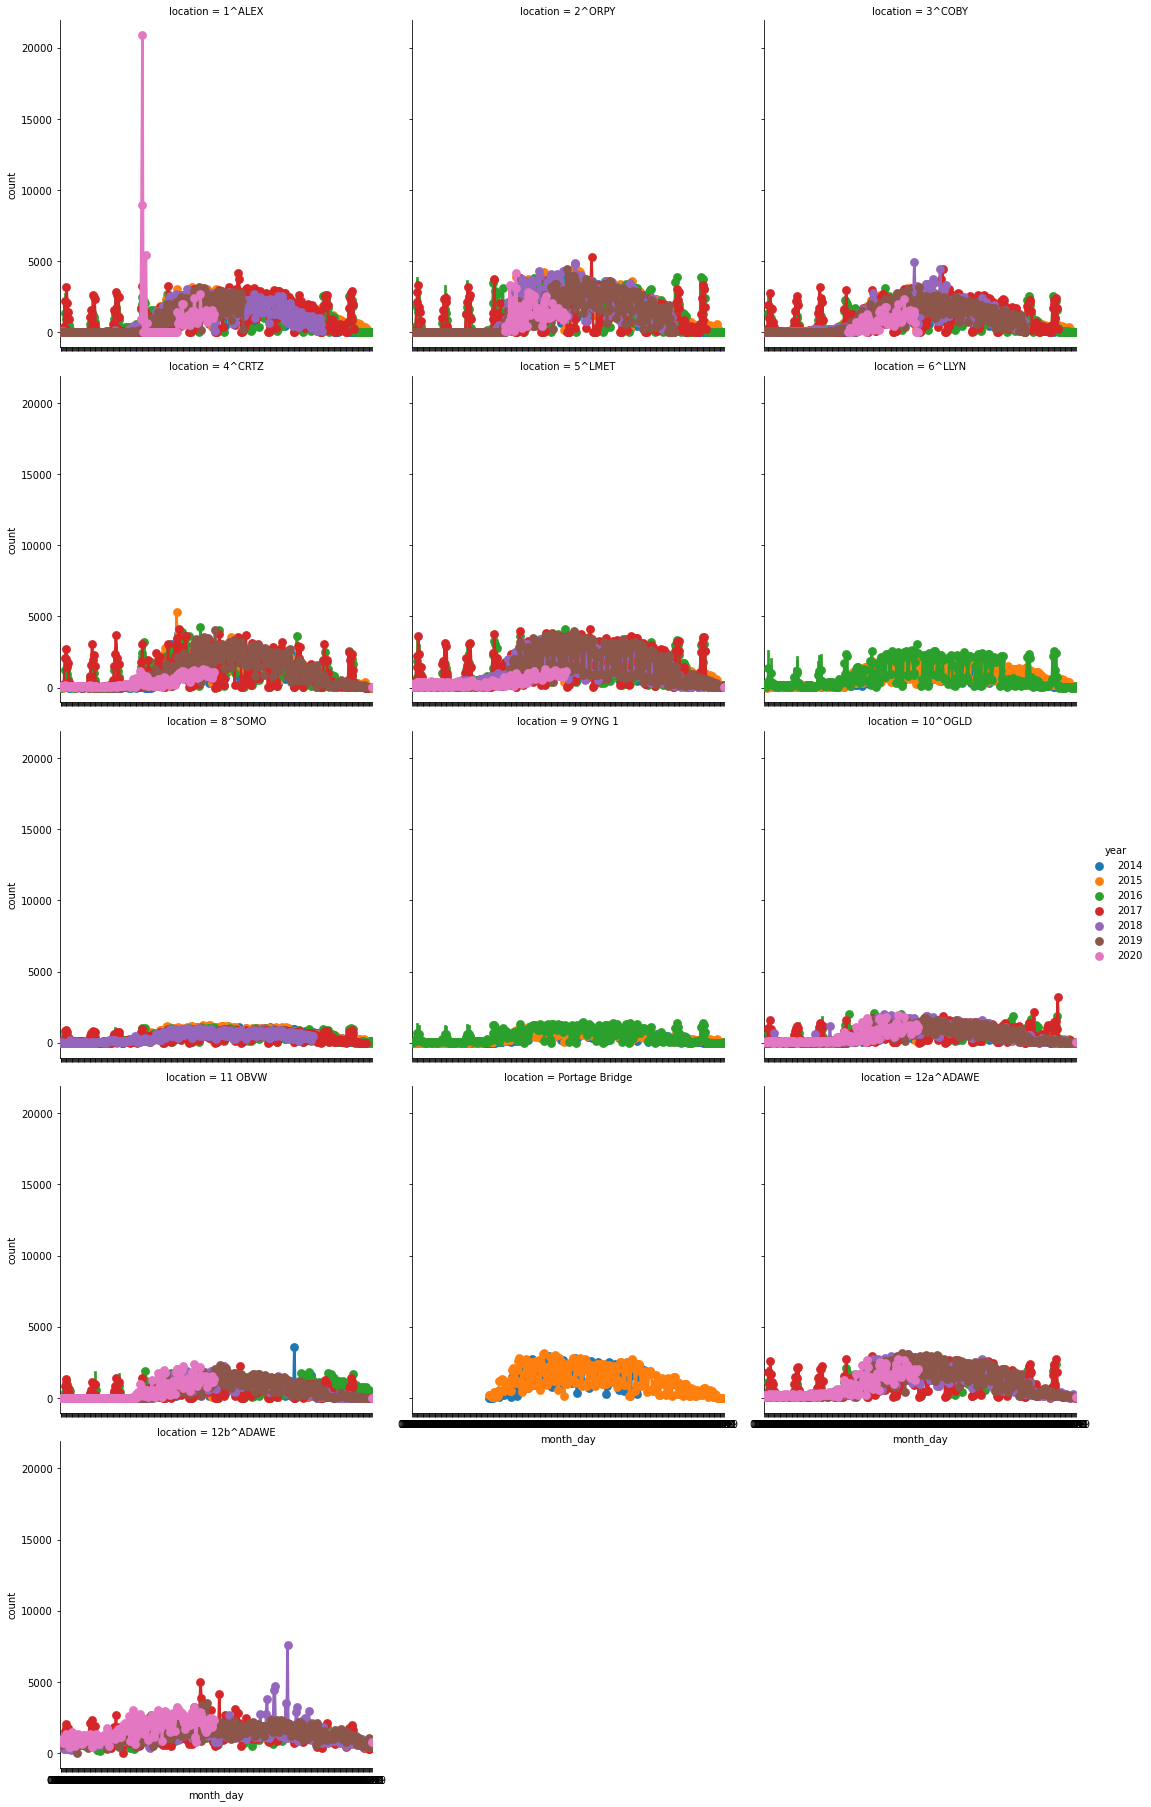

In [20]:
# plot all locations?
# this takes a super long time to run!
sns.catplot(x = 'month_day', y = 'count', col = 'location', col_wrap = 3, data = count_data, 
              hue = 'year', kind = 'point')

## Plot a single location

As a first fun thing, it could be neat to look for a covid-related change in bike counts.
What do we expect: commuting decreased, recreational cycling increased?

In [21]:
# look for a covid-related signal at one location for starters?
# 3_COBY: NCC Eastern Canal Pathway approximately 100m north of the Corktown Bridge. WINTER counter 
canal_path_corktown = count_data[count_data['location'] == '3^COBY']

In [22]:
canal_path_grouped_by_year = canal_path_corktown.groupby('year')

In [23]:
canal_path_grouped = canal_path_corktown.groupby(['year', 'month'])

In [24]:
canal_path_stats = canal_path_grouped['count'].agg(['mean', 'std', 'sum'])


Text(0, 0.5, 'Bike count')

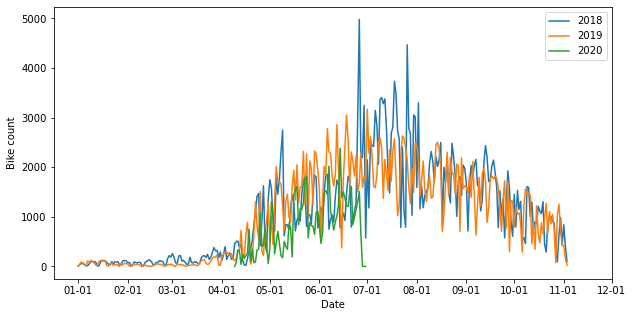

In [25]:
fig, ax = plt.subplots(figsize = (10,5))

for group in canal_path_grouped_by_year:
    year = group[0]
    data = group[1]
    
    if year < 2018:
        continue
    
    ax.plot(data['month_day'], data['count'], label = str(year))

ax.legend(loc = 'upper right')

ax.set_xticks(['01-01', '02-01','03-01','04-01','05-01','06-01','07-01','08-01','09-01','10-01', '11-01', '12-01'])
ax.set_xlabel("Date")
ax.set_ylabel("Bike count")

In [26]:
canal_path_corktown_recent = canal_path_corktown[(canal_path_corktown['year'] > 2016)]

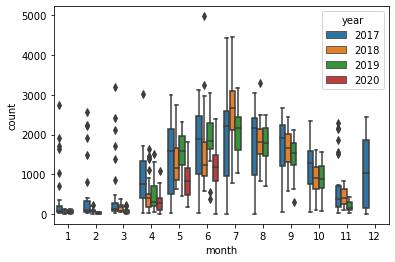

In [27]:
sns.boxplot(x='month', y='count', data=canal_path_corktown_recent, hue = 'year')
plt.savefig("bike_counts_by_month_canal_path_corktown_east.png", dpi = 150)

In [28]:
count_data_recent = count_data[(count_data['year'] > 2016)]

In [29]:
count_data_recent = count_data_recent[(count_data['location'] != '6^LLYN') & 
                 (count_data['location'] != '9 OYNG 1') &
                 (count_data['location'] != 'Portage Bridge')]

<ipython-input-29-8768bc3ff1b8>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  count_data_recent = count_data_recent[(count_data['location'] != '6^LLYN') &


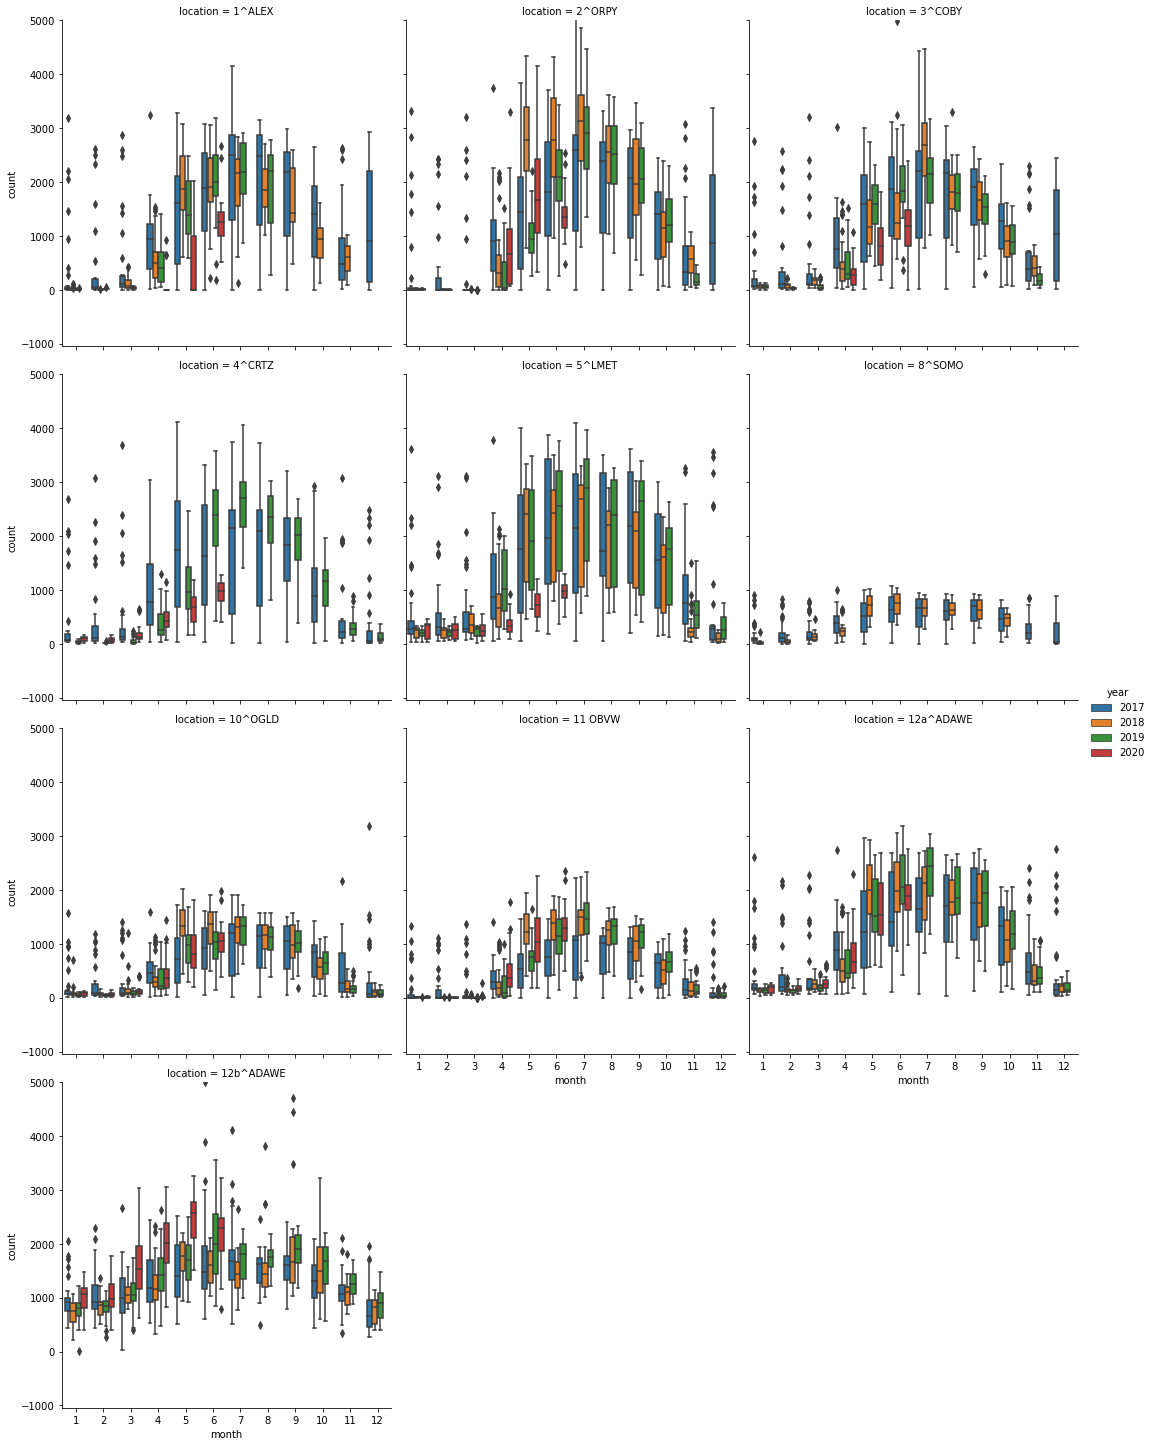

In [30]:
g = sns.catplot(x = 'month', y = 'count', col = 'location', col_wrap = 3, data = count_data_recent, 
              hue = 'year', kind = 'box')
g.set(ylim=(None, 5000))
plt.savefig("bike_counts_2017_2020_all_locations.png", dpi = 200)